In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

In [ ]:
pip install transformers

In [ ]:
from google.colab import drive
drive.mount('//content//drive')

Mounted at //content//drive


In [ ]:
pp_ds=pd.read_csv("/content/drive/MyDrive/DS_CSE 438/Dataset/Daridataset/df_resampled.csv")

In [ ]:
pp_ds

,tweets,category,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD,0
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE,1
2,کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...,SAD,0
3,چون همش با دوربین ثبت شده ایا میشه اعتراض زد ...,OTHER,2
4,اين وضع ب طرز خنده داري گريه داره,SAD,0
...,...,...,...
12994,عجب حرکتی کیش و مات,SURPRISE,6
12995,مگه اسم تعیین کنندهس,SURPRISE,6
12996,واقعا ادم حیرت میکنه از این سخنان نابخردانه,SURPRISE,6
12997,من نمیدونم از خودم برای دیگران چه تصویری ساخته...,SURPRISE,6


# Create a 85-15 train-test split.



In [ ]:
import numpy as np
df_train, df_test = np.split(pp_ds.sample(frac=1, random_state=4040), [int(.85*len(pp_ds))])
print('{:>5,} training samples'.format(len(df_train)))
print('{:>5,} test samples'.format(len(df_test)))

11,049 training samples
1,950 test samples


In [ ]:
df_train['label'] = df_train['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_train = df_train.reset_index(drop=True)
comments_a = df_train['tweets'].tolist()
labels = df_train['label'].tolist()
num_labels = len(df_train['label'].unique())
print(df_train.shape)
pp_ds

(11049, 3)


,tweets,category,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD,0
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE,1
2,کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...,SAD,0
3,چون همش با دوربین ثبت شده ایا میشه اعتراض زد ...,OTHER,2
4,اين وضع ب طرز خنده داري گريه داره,SAD,0
...,...,...,...
12994,عجب حرکتی کیش و مات,SURPRISE,6
12995,مگه اسم تعیین کنندهس,SURPRISE,6
12996,واقعا ادم حیرت میکنه از این سخنان نابخردانه,SURPRISE,6
12997,من نمیدونم از خودم برای دیگران چه تصویری ساخته...,SURPRISE,6


#Using Colab GPU for Training

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


#Preparing train data

In [ ]:
from transformers import AutoTokenizer

# Using Multilingual BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

##Encoding the data

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:

    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])


comment_a:  عجب دستاورد هایی شما شاخ غول رو شکستید
Token IDs: tensor([   101,    781,  50576,  21246, 109773,  10658,  68298,  10278,  97548,
           776,  66085,    782,  14358,  55532,  49011,  19171,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,   

#Import the Multilingual BERT model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AdamW

num_classes = 7

# Using Multilingual BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,
)
config = AutoConfig.from_pretrained("bert-base-multilingual-cased")
if device.type == 'cuda':
  model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Combine the training inputs into a TensorDataset

In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} training samples'.format(len(train_dataset)))

11,049 training samples


In [ ]:
labels

tensor([6, 1, 1,  ..., 1, 5, 6])

##Create dataloaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

##Create Optimizer, Scheduler, Accuracy, Elapsed time

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

##Training loop

In [ ]:
import random
import numpy as np
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_token_type_ids =  batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    691.    Elapsed: 0:00:34.
  Batch    80  of    691.    Elapsed: 0:01:07.
  Batch   120  of    691.    Elapsed: 0:01:37.
  Batch   160  of    691.    Elapsed: 0:02:08.
  Batch   200  of    691.    Elapsed: 0:02:40.
  Batch   240  of    691.    Elapsed: 0:03:11.
  Batch   280  of    691.    Elapsed: 0:03:42.
  Batch   320  of    691.    Elapsed: 0:04:13.
  Batch   360  of    691.    Elapsed: 0:04:44.
  Batch   400  of    691.    Elapsed: 0:05:15.
  Batch   440  of    691.    Elapsed: 0:05:46.
  Batch   480  of    691.    Elapsed: 0:06:18.
  Batch   520  of    691.    Elapsed: 0:06:49.
  Batch   560  of    691.    Elapsed: 0:07:20.
  Batch   600  of    691.    Elapsed: 0:07:51.
  Batch   640  of    691.    Elapsed: 0:08:22.
  Batch   680  of    691.    Elapsed: 0:08:53.

  Average training loss: 1.56
  Training epcoh took: 0:09:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    691.    Elapsed: 0:00:31.
  Batc

# Preparing test data

In [ ]:
df_test['label'] = df_test['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_test = df_test.reset_index(drop=True)

comments_a = df_test['tweets'].tolist()
labels = df_test['label'].tolist()
num_labels = len(df_test['label'].unique())

print(df_test.shape)
df_test.head(5)

(1950, 3)


,tweets,category,label
0,یه همکار خیلی خوب و آدم حسابی داشتم فقط یه ...,SURPRISE,6
1,سلام سال نو مبارک بهترين ها رو براتونآرز...,HAPPY,5
2,میتونم این مبحث فرار از اسپویل فیلمها رو درک ک...,OTHER,2
3,شب چهارشنبه آخر سال فرصتی است ویژه که در کنار ...,HAPPY,5
4,من میگم چرا فالوت نداشتم تعجب کردم,SURPRISE,6


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:
    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])

comment_a:     یه همکار خیلی خوب و آدم حسابی داشتم فقط یه عیبی داشت هر وقت بازخواستش میکردم و ازش ناراحت میشدم میخندید یه بار دیگه عصبانی شدم گفتم خانم یه دفعه دیگه بخندی اخراجت میکنم  همونطور که میخندید اشکش سرازیر شد گفت من عصبی که میشم و میترسم میخندم    دیگه شدیم بهترین رفیق همدیگه
Token IDs: tensor([   101,    834,  10388,  16079,  21009,    770,  34084, 107459,    791,
           758,  53595,  62964,  10278,  20995,  10700,  23155,    834,  10388,
           781,  38979,  10278,  20995,  17534,  22198,  53349,  90912,  11626,
         39387,  10700,    791,  10383,  11626,    789,  57980,  41002,  37426,
         10700,  29869,  95755,  76719,    834,  10388,  23248,  12687,  65985,
           781,  58678,  16163,  11879,  10700,  52243,  10700,  23027,  10700,
           834,  10388, 101035,  10388,  12687,  65985,    764,  95755,  15519,
           763,  63865,  10502,  29869,  37951,  10700,  16079,  11326,  48312,
         10498,  29869,  95755,  76719,  92118,  82627,  28340

In [ ]:
test_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} test samples'.format(len(test_dataset)))
batch_size = 32
prediction_data = test_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

1,950 test samples


#Model Evaluation on Test Data

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))
model.eval()
predictions , true_labels = [], []
total_eval_accuracy=0

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_token_type, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids= b_token_type,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
  total_eval_accuracy += flat_accuracy(logits, label_ids)
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

Predicting labels for 1,950 test sentences...
  Accuracy: 0.812


In [ ]:
from sklearn import metrics
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
f1_score_micro = metrics.f1_score(labels, preds_flat, average='macro')
print("  f1_score: {0:.3f}".format(f1_score_micro))

  f1_score: 0.807


In [ ]:
from sklearn.metrics import precision_score, recall_score
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
precision = precision_score(labels, preds_flat, average='macro')
recall = recall_score(labels, preds_flat, average='macro')
print("  Precision: {0:.3f}".format(precision))
print("  Recall: {0:.3f}".format(recall))


  Precision: 0.806
  Recall: 0.813


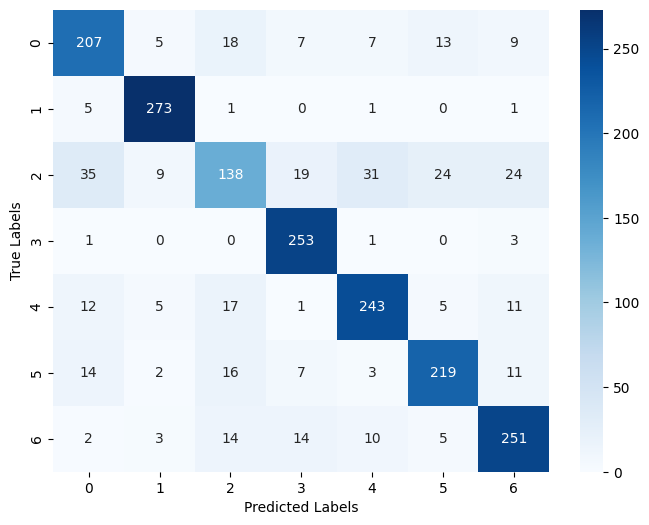

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
conf_matrix = confusion_matrix(labels, preds_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


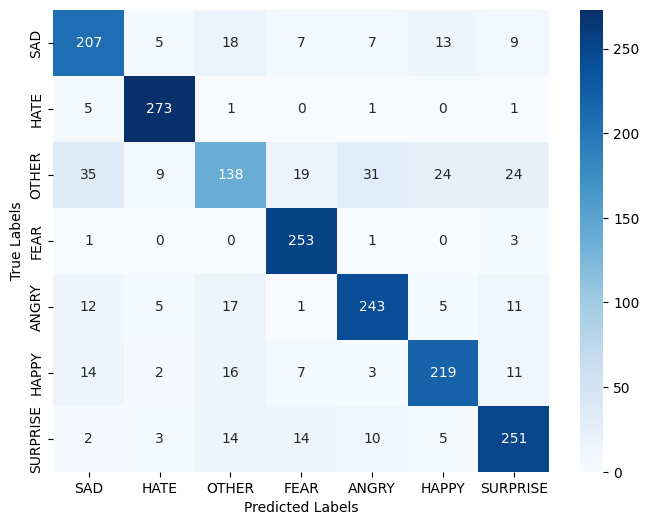

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
class_labels = ['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE']

preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


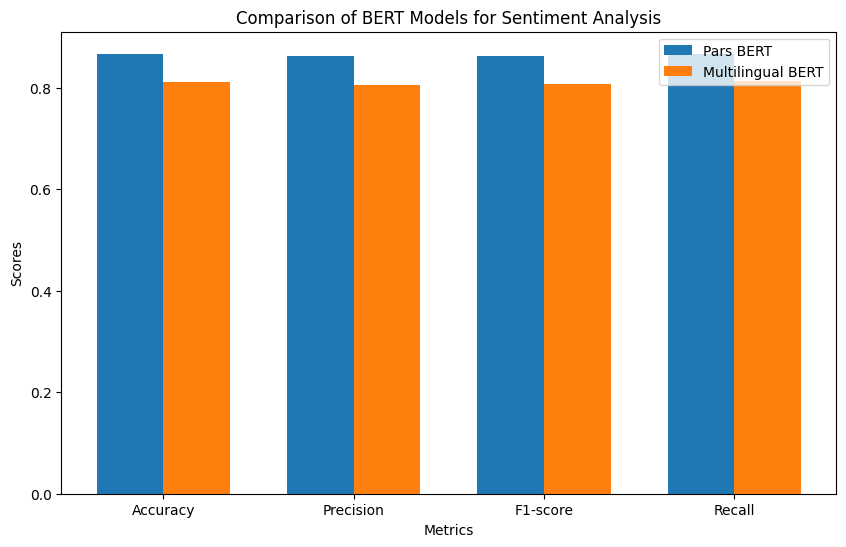

In [11]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of BERT Models for Sentiment Analysis')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

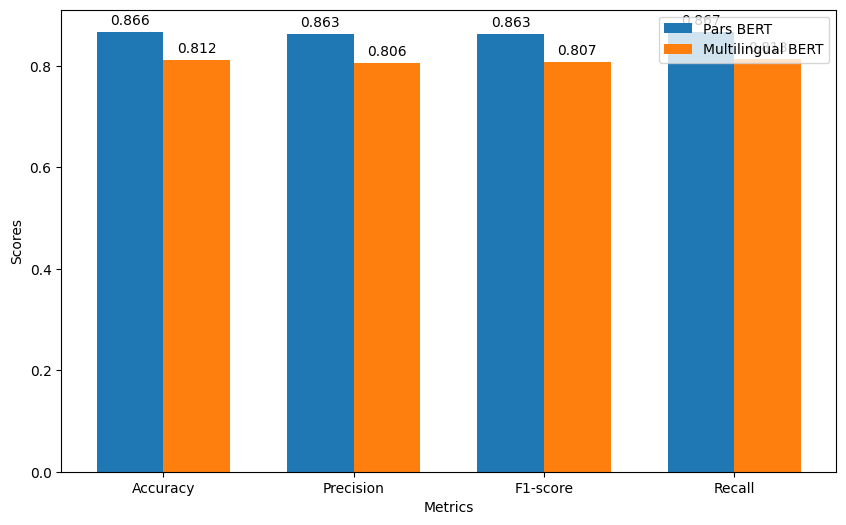

In [9]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
def add_values_on_top(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values_on_top(bar1)
add_values_on_top(bar2)
plt.show()
